## QTM151 Final Project – Section 1
### Evaluating the Predictive Relationship Between Qualifying and Final Race Positions for Mercedes and Red Bull
**Team Members:** Shourya Soni, Jack Chapon, Xiyue Yue

### Introduction

Formula 1 is a high-performance international racing sport where strategy and precision play a major role. Each race weekend includes a qualifying session that determines the starting grid. It is commonly believed that starting near the front leads to a better chance of winning.

This project analyzes whether a driver’s qualifying position can predict their final race result and whether this relationship differs between two dominant F1 teams: **Mercedes** and **Red Bull**. Using official race data, we explore this question by calculating correlation, visualizing team performance across qualifying spots, and applying regression models. Our goal is to uncover whether one team gains more strategic advantage from good qualifying.


### Data Description

We use the following datasets from the Formula 1 database:
- **`qualifying.csv`**: Each row represents a driver's qualifying result in a race.
- **`results.csv`**: Each row represents a driver's final result in a race.
- **`constructors.csv`**: Contains metadata about the constructor (team).

We use `raceId`, `driverId`, and `constructorId` as keys to merge the tables. Our final dataset includes qualifying position, final race position, and constructor name for each entry.

We count the number of rows and columns in each dataset and describe our main analysis columns in detail.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


qualifying = pd.read_csv("data_raw/qualifying.csv")
results = pd.read_csv("data_raw/results.csv")
constructors = pd.read_csv("data_raw/constructors.csv")



In [39]:
qualifying = qualifying[['raceId', 'driverId', 'constructorId', 'position']]
results = results[['raceId', 'driverId', 'constructorId', 'positionOrder']]
constructors = constructors[['constructorId', 'name']]

# Rename for clarity
qualifying = qualifying.rename(columns = {'position': 'qualifying_position'})
results = results.rename(columns = {'positionOrder': 'final_position'})
constructors = constructors.rename(columns = {'name': 'constructor_name'})

# Drop missing rows
qualifying = qualifying.dropna()
results = results.dropna()

# Convert to integers
qualifying["qualifying_position"] = qualifying["qualifying_position"].astype(int)
results["final_position"] = results["final_position"].astype(int)


In [40]:
merged = pd.merge(qualifying, results, on=["raceId", "driverId", "constructorId"])
merged = pd.merge(merged, constructors, on="constructorId")

# Keep only Mercedes and Red Bull
merged = merged.query("constructor_name == 'Mercedes' or constructor_name == 'Red Bull'")



In [41]:
print("Number of rows:", len(merged))
print("Number of columns:", merged.shape[1])
print(merged[['qualifying_position', 'final_position']].describe())


Number of rows: 1211
Number of columns: 6
       qualifying_position  final_position
count          1211.000000     1211.000000
mean              5.587944        6.820809
std               4.633277        6.206776
min               1.000000        1.000000
25%               2.000000        2.000000
50%               4.000000        4.000000
75%               8.000000        9.000000
max              23.000000       24.000000


In [50]:
# Mercedes
mean_q_m = mercedes["qualifying_position"].mean()
std_q_m = mercedes["qualifying_position"].std()
mean_f_m = mercedes["final_position"].mean()
std_f_m = mercedes["final_position"].std()

print("Mercedes Qualifying - Mean:", mean_q_m, "| Std Dev:", std_q_m)
print("Mercedes Final - Mean:", mean_f_m, "| Std Dev:", std_f_m)

# Red Bull
mean_q_r = redbull["qualifying_position"].mean()
std_q_r = redbull["qualifying_position"].std()
mean_f_r = redbull["final_position"].mean()
std_f_r = redbull["final_position"].std()

print("Red Bull Qualifying - Mean:", mean_q_r, "| Std Dev:", std_q_r)
print("Red Bull Final - Mean:", mean_f_r, "| Std Dev:", std_f_r)


Mercedes Qualifying - Mean: 11.681818181818182 | Std Dev: 6.763954631063269
Mercedes Final - Mean: 8.487490447269948 | Std Dev: 4.097284674042876
Red Bull Qualifying - Mean: 11.5 | Std Dev: 6.493586579592718
Red Bull Final - Mean: 10.20237035787795 | Std Dev: 3.5310859111944266


In [51]:
# Mercedes Top 5 Qualifiers
mercedes_top5 = mercedes.query("qualifying_position <= 5")
print("Mercedes Top 5 Qualifiers:", len(mercedes_top5))

# Red Bull Top 5 Qualifiers
redbull_top5 = redbull.query("qualifying_position <= 5")
print("Red Bull Top 5 Qualifiers:", len(redbull_top5))

# Compare average final positions
print("Mercedes Top 5 Avg Final:", mercedes_top5["final_position"].mean())
print("Red Bull Top 5 Avg Final:", redbull_top5["final_position"].mean())


Mercedes Top 5 Qualifiers: 5
Red Bull Top 5 Qualifiers: 5
Mercedes Top 5 Avg Final: 4.876825141734744
Red Bull Top 5 Avg Final: 5.648768699306451


In [56]:
# Group and print manually
grouped = merged.groupby(["constructor_name", "qualifying_position"])["final_position"].mean().reset_index()

# Print top 10 qualifying positions for both
for i in range(1, 23):
    m_avg = grouped.query("constructor_name == 'Mercedes' and qualifying_position == @i")["final_position"]
    r_avg = grouped.query("constructor_name == 'Red Bull' and qualifying_position == @i")["final_position"]
    if not m_avg.empty and not r_avg.empty:
        print("Q Position:", i, 
              "| Mercedes Final Avg:", round(m_avg.values[0], 2), 
              "| Red Bull Final Avg:", round(r_avg.values[0], 2))


Q Position: 1 | Mercedes Final Avg: 3.12 | Red Bull Final Avg: 2.86
Q Position: 2 | Mercedes Final Avg: 3.86 | Red Bull Final Avg: 5.28
Q Position: 3 | Mercedes Final Avg: 5.25 | Red Bull Final Avg: 5.44
Q Position: 4 | Mercedes Final Avg: 5.18 | Red Bull Final Avg: 6.6
Q Position: 5 | Mercedes Final Avg: 6.97 | Red Bull Final Avg: 8.06
Q Position: 6 | Mercedes Final Avg: 6.03 | Red Bull Final Avg: 7.56
Q Position: 7 | Mercedes Final Avg: 8.35 | Red Bull Final Avg: 8.69
Q Position: 8 | Mercedes Final Avg: 12.05 | Red Bull Final Avg: 8.61
Q Position: 9 | Mercedes Final Avg: 12.65 | Red Bull Final Avg: 8.22
Q Position: 10 | Mercedes Final Avg: 8.33 | Red Bull Final Avg: 10.17
Q Position: 11 | Mercedes Final Avg: 10.14 | Red Bull Final Avg: 11.71
Q Position: 12 | Mercedes Final Avg: 8.88 | Red Bull Final Avg: 9.48
Q Position: 13 | Mercedes Final Avg: 10.25 | Red Bull Final Avg: 13.33
Q Position: 14 | Mercedes Final Avg: 9.5 | Red Bull Final Avg: 13.25
Q Position: 15 | Mercedes Final Avg: 

We focus on:
- `qualifying_position`: the starting grid position.
- `final_position`: the race result.
- `constructor_name`: the team name.

The `.describe()` output shows mean, standard deviation, and min/max values for each.


In [42]:
mercedes = merged.query("constructor_name == 'Mercedes'")
redbull = merged.query("constructor_name == 'Red Bull'")



In [43]:
model_m = smf.ols(formula = 'final_position ~ qualifying_position', data = mercedes)
results_m = model_m.fit()
b_m = results_m.params

# Predict values
mercedes['p_hat'] = b_m[0] + b_m[1] * mercedes['qualifying_position']





C:\Users\shour\AppData\Local\Temp\ipykernel_64480\1909530758.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mercedes['p_hat'] = b_m[0] + b_m[1] * mercedes['qualifying_position']
C:\Users\shour\AppData\Local\Temp\ipykernel_64480\1909530758.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mercedes['p_hat'] = b_m[0] + b_m[1] * mercedes['qualifying_position']


In [44]:
model_r = smf.ols(formula = 'final_position ~ qualifying_position', data = redbull)
results_r = model_r.fit()
b_r = results_r.params

# Predict values
redbull['p_hat'] = b_r[0] + b_r[1] * redbull['qualifying_position']


C:\Users\shour\AppData\Local\Temp\ipykernel_64480\4087137767.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  redbull['p_hat'] = b_r[0] + b_r[1] * redbull['qualifying_position']
C:\Users\shour\AppData\Local\Temp\ipykernel_64480\4087137767.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  redbull['p_hat'] = b_r[0] + b_r[1] * redbull['qualifying_position']


In [45]:
# Mercedes errors
mercedes['error'] = mercedes['final_position'] - mercedes['p_hat']
mercedes['error_squared'] = mercedes['error'] ** 2

# Red Bull errors
redbull['error'] = redbull['final_position'] - redbull['p_hat']
redbull['error_squared'] = redbull['error'] ** 2

# Print MSE
print("Mercedes MSE:", mercedes['error_squared'].mean())
print("Red Bull MSE:", redbull['error_squared'].mean())


Mercedes MSE: 28.616726427021717
Red Bull MSE: 32.36911777610261


C:\Users\shour\AppData\Local\Temp\ipykernel_64480\2810984492.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mercedes['error'] = mercedes['final_position'] - mercedes['p_hat']
C:\Users\shour\AppData\Local\Temp\ipykernel_64480\2810984492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mercedes['error_squared'] = mercedes['error'] ** 2
C:\Users\shour\AppData\Local\Temp\ipykernel_64480\2810984492.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

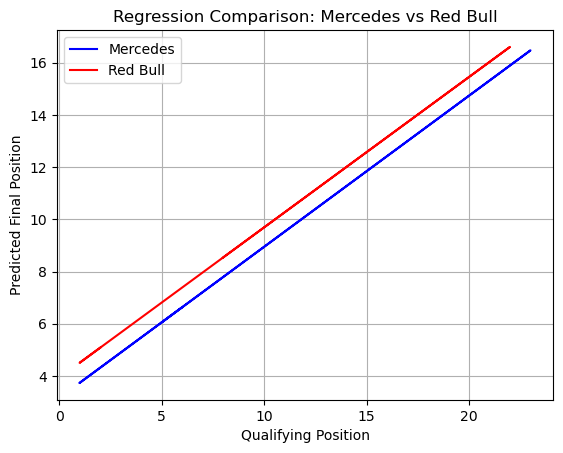

In [46]:
plt.plot(mercedes["qualifying_position"], mercedes["p_hat"], label = "Mercedes", color = "blue")
plt.plot(redbull["qualifying_position"], redbull["p_hat"], label = "Red Bull", color = "red")
plt.xlabel("Qualifying Position")
plt.ylabel("Predicted Final Position")
plt.title("Regression Comparison: Mercedes vs Red Bull")
plt.legend()
plt.grid(True)
plt.show()



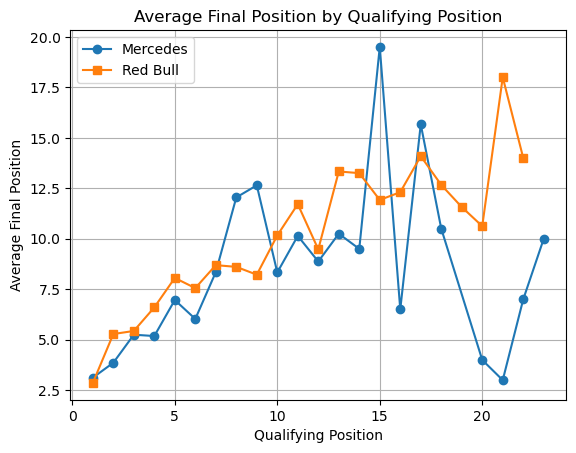

In [49]:
grouped = merged.groupby(["constructor_name", "qualifying_position"])["final_position"].mean().reset_index()

mercedes = grouped.query("constructor_name == 'Mercedes'")
redbull = grouped.query("constructor_name == 'Red Bull'")

plt.plot(mercedes["qualifying_position"], mercedes["final_position"], label = "Mercedes", marker = "o")
plt.plot(redbull["qualifying_position"], redbull["final_position"], label = "Red Bull", marker = "s")

plt.xlabel("Qualifying Position")
plt.ylabel("Average Final Position")
plt.title("Average Final Position by Qualifying Position")
plt.legend()
plt.grid(True)
plt.show()

